## Percobaan 1

Tanpa Preprocessing

In [1]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

## Data Loading

In [2]:
data = []
labels = []
file_name = []

for sub_folder in os.listdir("dataset\\"):
    sub_folder_files = os.listdir(os.path.join("dataset\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset\\", sub_folder, filename)
        img = cv.imread(img_path)
        if img is not None:
            # Ambil channel hijau dari gambar
            green = img[:, :, 1]
            green = cv.resize(green, (150, 150)) # Resize gambar yag diambil
            green = green.astype(np.uint8)

            # img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            # img = cv.resize(img, (150, 150))  # Resize ke ukuran tetap
            # img = img.astype(np.uint8)

            data.append(green)
            labels.append(sub_folder)
            name = os.path.splitext(filename)[0]
            file_name.append(filename)

data = np.array(data)
labels = np.array(labels)

## Data Preparation

### Tanpa Preprocessing

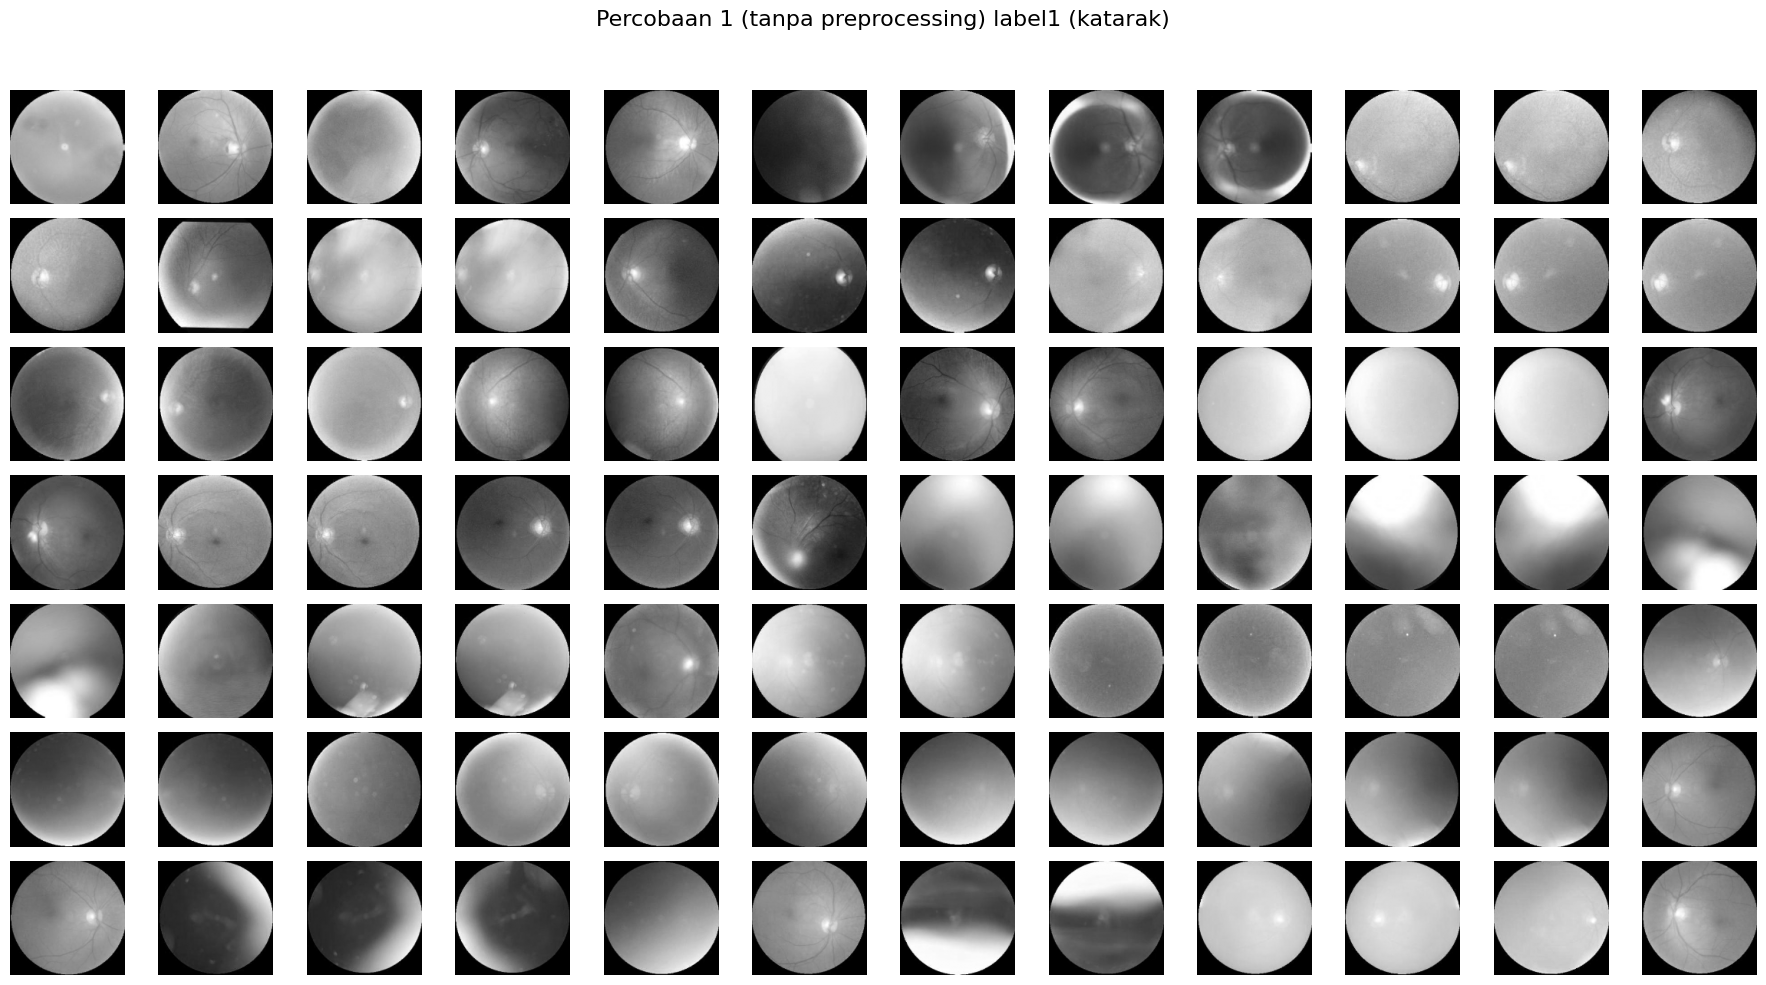

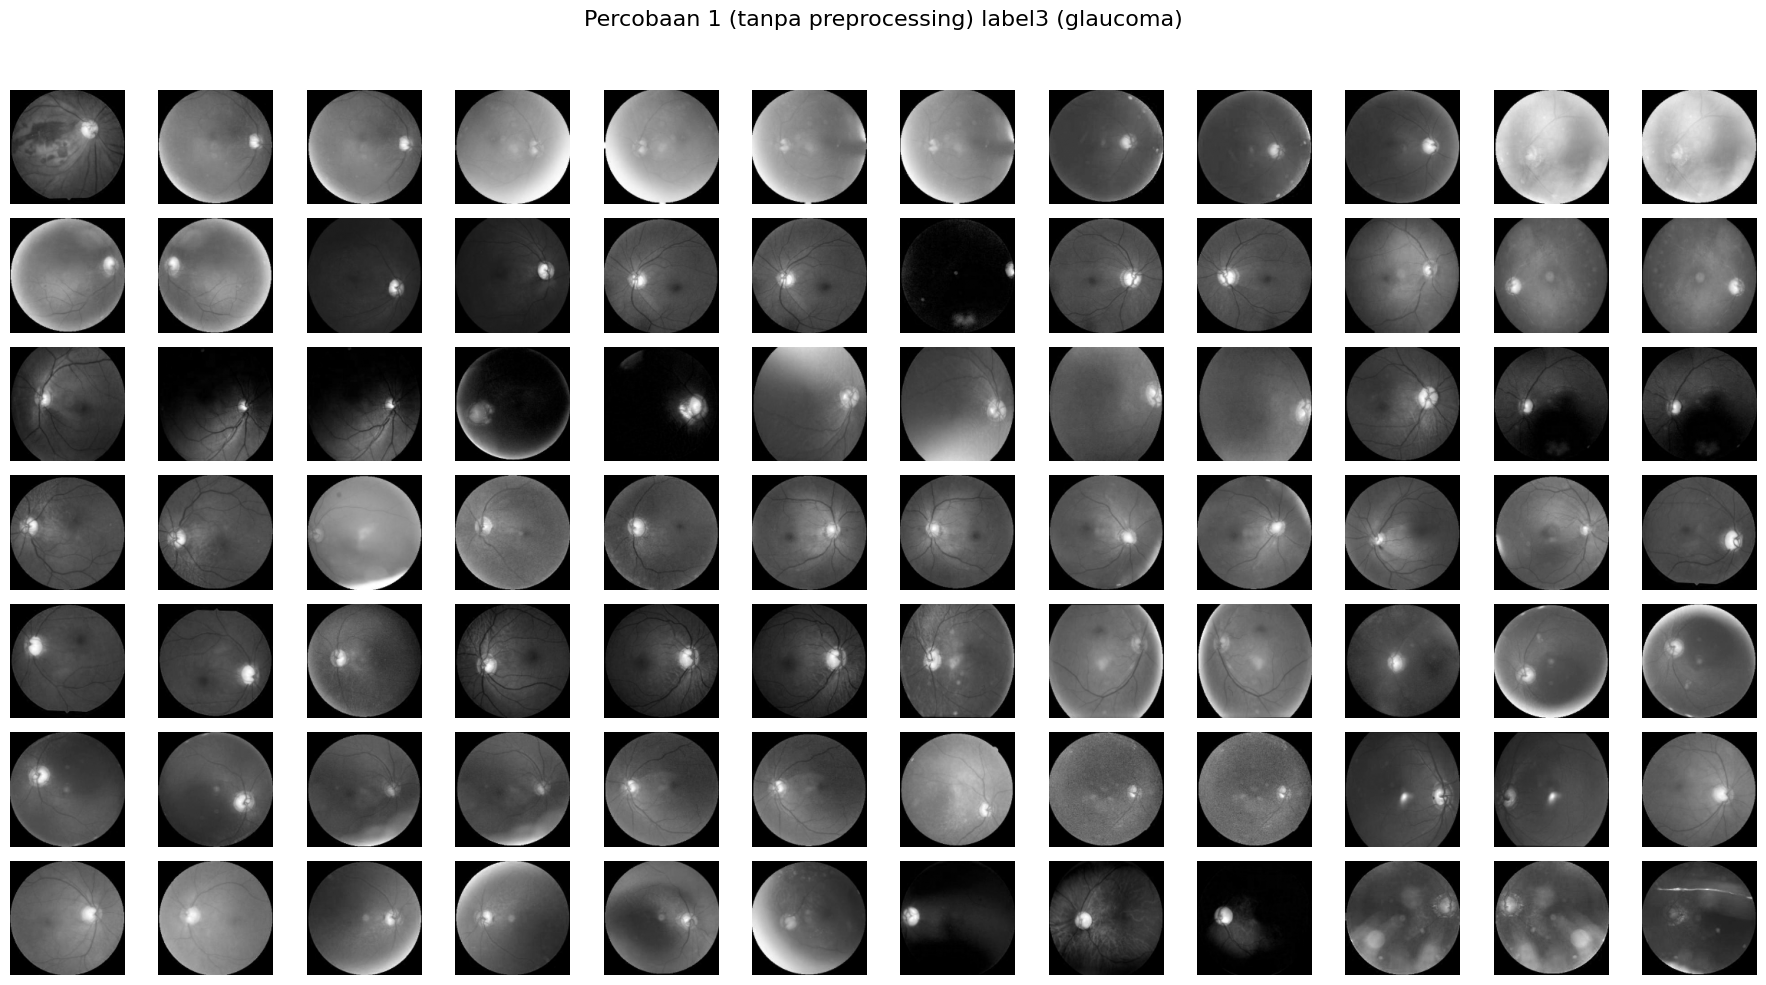

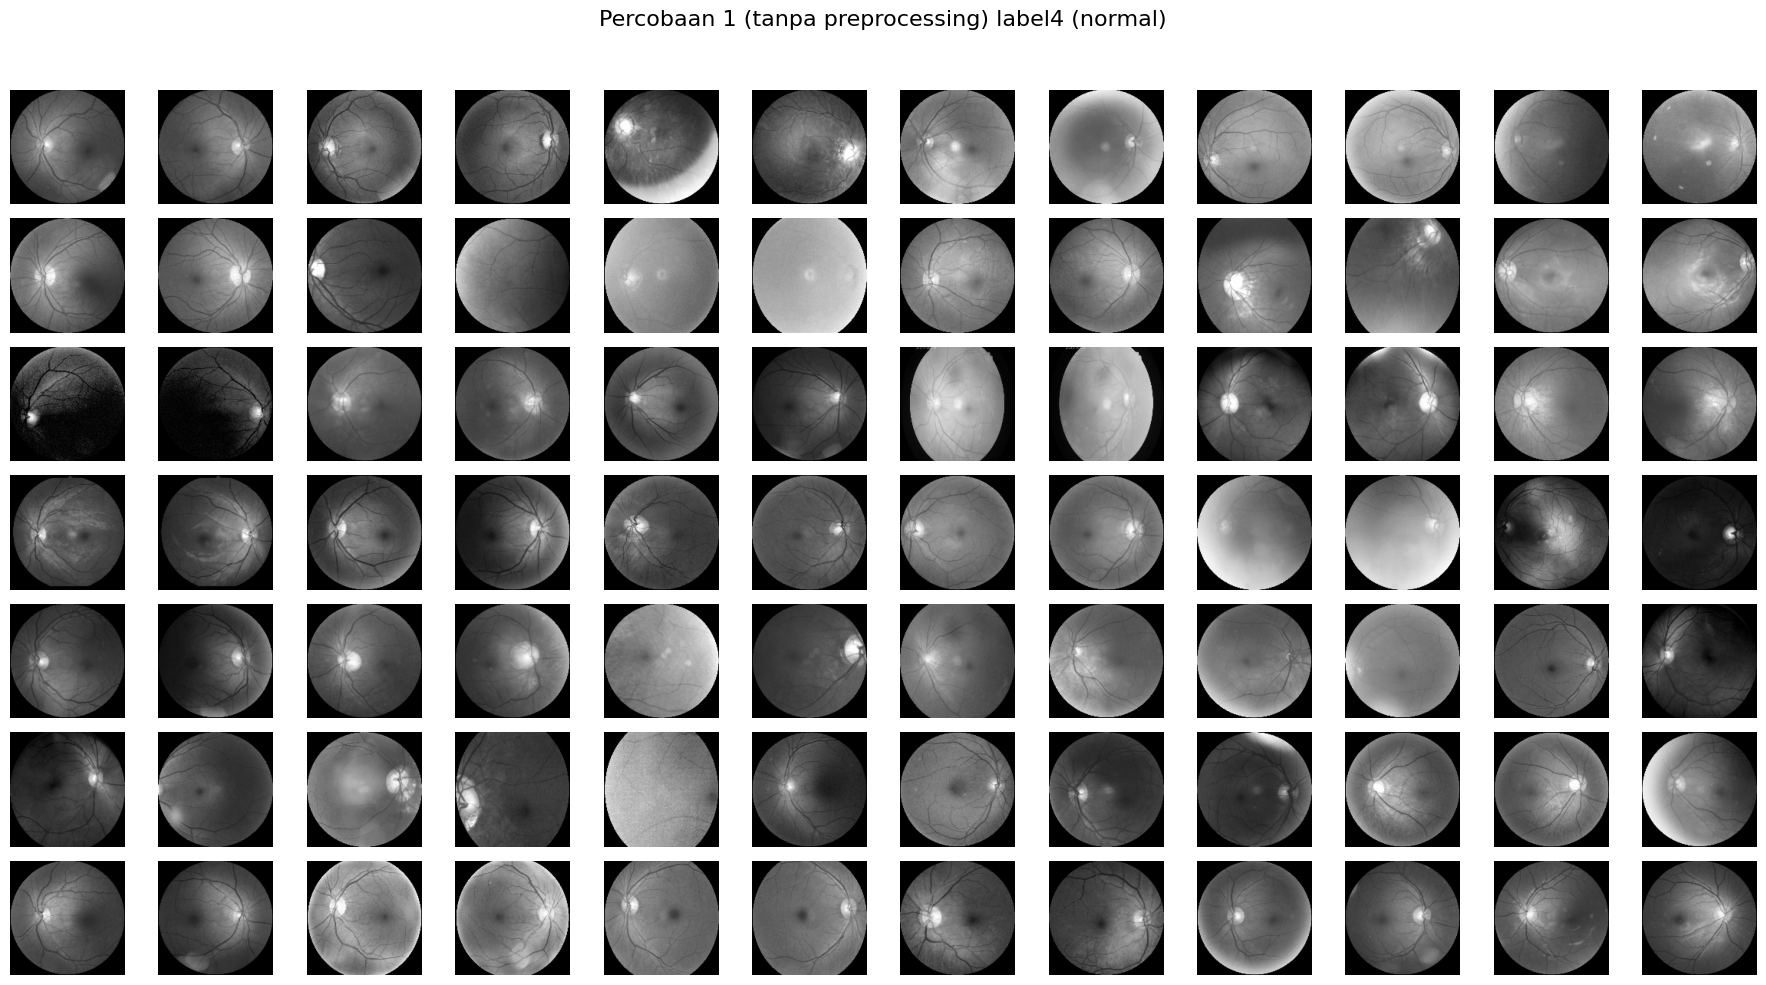

In [3]:
unique_labels = sorted(set(labels))

for label in unique_labels:
    # Ambil semua indeks gambar dari label ini
    idxs = [j for j, l in enumerate(labels) if l == label]
    
    # Buat grid 7x12 (cukup untuk 84 gambar, 7*12 = 84)
    fig, axs = plt.subplots(7, 12, figsize=(18, 10))
    fig.suptitle(f'Percobaan 1 (tanpa preprocessing) {label}', fontsize=16)
    
    for k in range(84):
        row = k // 12
        col = k % 12
        ax = axs[row][col]
        ax.imshow(data[idxs[k]], cmap='gray')  # Ganti dengan data asli
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # beri ruang untuk judul
    plt.show()


## Ekstrasi Fitur

In [4]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    
    return glcm

In [5]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [6]:
# Fungsi ekstraksi fitur untuk list citra
def ekstrak_fitur_glcm(data, nama_prepro):
    fitur_list = []
    for img in data:
        img_u8 = img.astype(np.uint8)
        m = glcm(img_u8, 0)  # derajat 0
        
        fitur = {
            'contrast': contrast(m),
            'correlation': correlation(m),
            'energy': energy(m),
            'homogeneity': homogenity(m),
            'dissimilarity': dissimilarity(m),
            'ASM': ASM(m),
            'entropy': entropyGlcm(m)
        }
        fitur_list.append(fitur)

    df = pd.DataFrame(fitur_list)
    df['tahap'] = nama_prepro
    return df

df1 = ekstrak_fitur_glcm(data, 'percobaan1')
display(df1)

contrast  correlation    energy  homogeneity  dissimilarity       ASM  \
0    212.481700     0.979981  0.160999     0.646901       3.124295  0.025921   
1    200.730559     0.978040  0.155645     0.472992       3.992841  0.024225   
2    175.714452     0.972585  0.152737     0.485527       3.510872  0.023329   
3     44.825503     0.978225  0.167849     0.589215       1.969575  0.028173   
4    112.321253     0.985644  0.160976     0.449094       3.561700  0.025913   
..          ...          ...       ...          ...            ...       ...   
331   72.402282     0.973985  0.178292     0.368015       4.332125  0.031788   
332  280.530336     0.947230  0.189634     0.412345       4.804609  0.035961   
333   80.413468     0.975651  0.192717     0.436694       3.602729  0.037140   
334   93.402058     0.970141  0.193372     0.427571       3.970380  0.037393   
335   77.251275     0.982158  0.193922     0.414634       4.136913  0.037606   

      entropy       tahap  
0    5.546064  percobaan1  
1    6.507146  percobaan1  
2    6.265902  percobaan1  
3    5.850370  percobaan1  
4    6.626018  percobaan1  
..        ...         ...  
331  6.693671  percobaan1  
332  6.554718  percobaan1  
333  6.296667  percobaan1  
334  6.327055  percobaan1  
335  6.570373  percobaan1  

[336 rows x 8 columns]

In [7]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(data)):
    D0 = glcm(data[i], 0)
    D45 = glcm(data[i], 45)
    D90 = glcm(data[i], 90)
    D135 = glcm(data[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

for i in range(len(data)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)



## Hasil Ekstraksi to CSV

In [8]:
features = []

for i in range(len(data)):
    fitur = [
        contrast(Derajat0[i]), contrast(Derajat45[i]), contrast(Derajat90[i]), contrast(Derajat135[i]),
        dissimilarity(Derajat0[i]), dissimilarity(Derajat45[i]), dissimilarity(Derajat90[i]), dissimilarity(Derajat135[i]),
        homogenity(Derajat0[i]), homogenity(Derajat45[i]), homogenity(Derajat90[i]), homogenity(Derajat135[i]),
        entropyGlcm(Derajat0[i]), entropyGlcm(Derajat45[i]), entropyGlcm(Derajat90[i]), entropyGlcm(Derajat135[i]),
        ASM(Derajat0[i]), ASM(Derajat45[i]), ASM(Derajat90[i]), ASM(Derajat135[i]),
        energy(Derajat0[i]), energy(Derajat45[i]), energy(Derajat90[i]), energy(Derajat135[i]),
        correlation(Derajat0[i]), correlation(Derajat45[i]), correlation(Derajat90[i]), correlation(Derajat135[i]),
    ]
    features.append(fitur)

# Buat dataframe
columns = [
    "contrast_0", "contrast_45", "contrast_90", "contrast_135",
    "dissimilarity_0", "dissimilarity_45", "dissimilarity_90", "dissimilarity_135",
    "homogeneity_0", "homogeneity_45", "homogeneity_90", "homogeneity_135",
    "entropy_0", "entropy_45", "entropy_90", "entropy_135",
    "ASM_0", "ASM_45", "ASM_90", "ASM_135",
    "energy_0", "energy_45", "energy_90", "energy_135",
    "correlation_0", "correlation_45", "correlation_90", "correlation_135"
]

df_fitur = pd.DataFrame(features, columns=columns)


In [9]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_percobaan1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_percobaan1.csv')
hasilEkstrak


Filename             Label   Contrast0  Contrast45  Contrast90  \
0     _0_4015166.jpg  label1 (katarak)  212.481700  355.912707  238.248680   
1    _10_3215668.jpg  label1 (katarak)  200.730559  291.410747  179.712931   
2    _11_7158929.jpg  label1 (katarak)  175.714452  292.831359  170.545638   
3    _12_5233869.jpg  label1 (katarak)   44.825503   63.847034   35.731902   
4    _13_3987009.jpg  label1 (katarak)  112.321253  184.231026  102.846488   
..               ...               ...         ...         ...         ...   
331      8_right.jpg   label4 (normal)   72.402282  108.367641   71.206846   
332     939_left.jpg   label4 (normal)  280.530336  425.357867  273.195660   
333    939_right.jpg   label4 (normal)   80.413468  117.373857   72.334049   
334     951_left.jpg   label4 (normal)   93.402058  151.891717   98.772796   
335    951_right.jpg   label4 (normal)   77.251275  118.969911   83.773468   

     Contrast135  Homogeneity0  Homogeneity45  Homogeneity90  Homogeneity135  \
0     404.770326      0.646901       0.561265       0.594900        0.524598   
1     327.858475      0.472992       0.413643       0.469370        0.407335   
2     295.713842      0.485527       0.432907       0.503792        0.431418   
3      70.024593      0.589215       0.529480       0.598242        0.516532   
4     176.911986      0.449094       0.398258       0.468117        0.405845   
..           ...           ...            ...            ...             ...   
331    98.784649      0.368015       0.340015       0.367169        0.341794   
332   412.139183      0.412345       0.368118       0.404712        0.372072   
333   108.879555      0.436694       0.413312       0.434607        0.402929   
334   128.611054      0.427571       0.397048       0.428150        0.406782   
335   116.304356      0.414634       0.380679       0.406492        0.379320   

     ...     ASM90    ASM135   Energy0  Energy45  Energy90  Energy135  \
0    ...  0.025515  0.023042  0.160999  0.152449  0.159733   0.151796   
1    ...  0.024412  0.022329  0.155645  0.149336  0.156242   0.149430   
2    ...  0.023470  0.021435  0.152737  0.147019  0.153201   0.146407   
3    ...  0.027720  0.025593  0.167849  0.160120  0.166494   0.159977   
4    ...  0.026402  0.024161  0.160976  0.155324  0.162487   0.155437   
..   ...       ...       ...       ...       ...       ...        ...   
331  ...  0.031828  0.029805  0.178292  0.173158  0.178404   0.172640   
332  ...  0.035870  0.033884  0.189634  0.183530  0.189393   0.184076   
333  ...  0.037046  0.034851  0.192717  0.186735  0.192474   0.186683   
334  ...  0.037643  0.035116  0.193372  0.187498  0.194017   0.187392   
335  ...  0.037648  0.035096  0.193922  0.187600  0.194032   0.187338   

     Correlation0  Correlation45  Correlation90  Correlation135  
0        0.979981       0.965990       0.977564        0.961321  
1        0.978040       0.967685       0.980343        0.963643  
2        0.972585       0.953703       0.973380        0.953247  
3        0.978225       0.968753       0.982632        0.965729  
4        0.985644       0.976206       0.986868        0.977152  
..            ...            ...            ...             ...  
331      0.973985       0.960784       0.974414        0.964251  
332      0.947230       0.919191       0.948616        0.921702  
333      0.975651       0.964083       0.978096        0.966682  
334      0.970141       0.950951       0.968427        0.958469  
335      0.982158       0.972318       0.980651        0.972938  

[336 rows x 30 columns]

## Feature Selection

### Correlation

<Axes: >

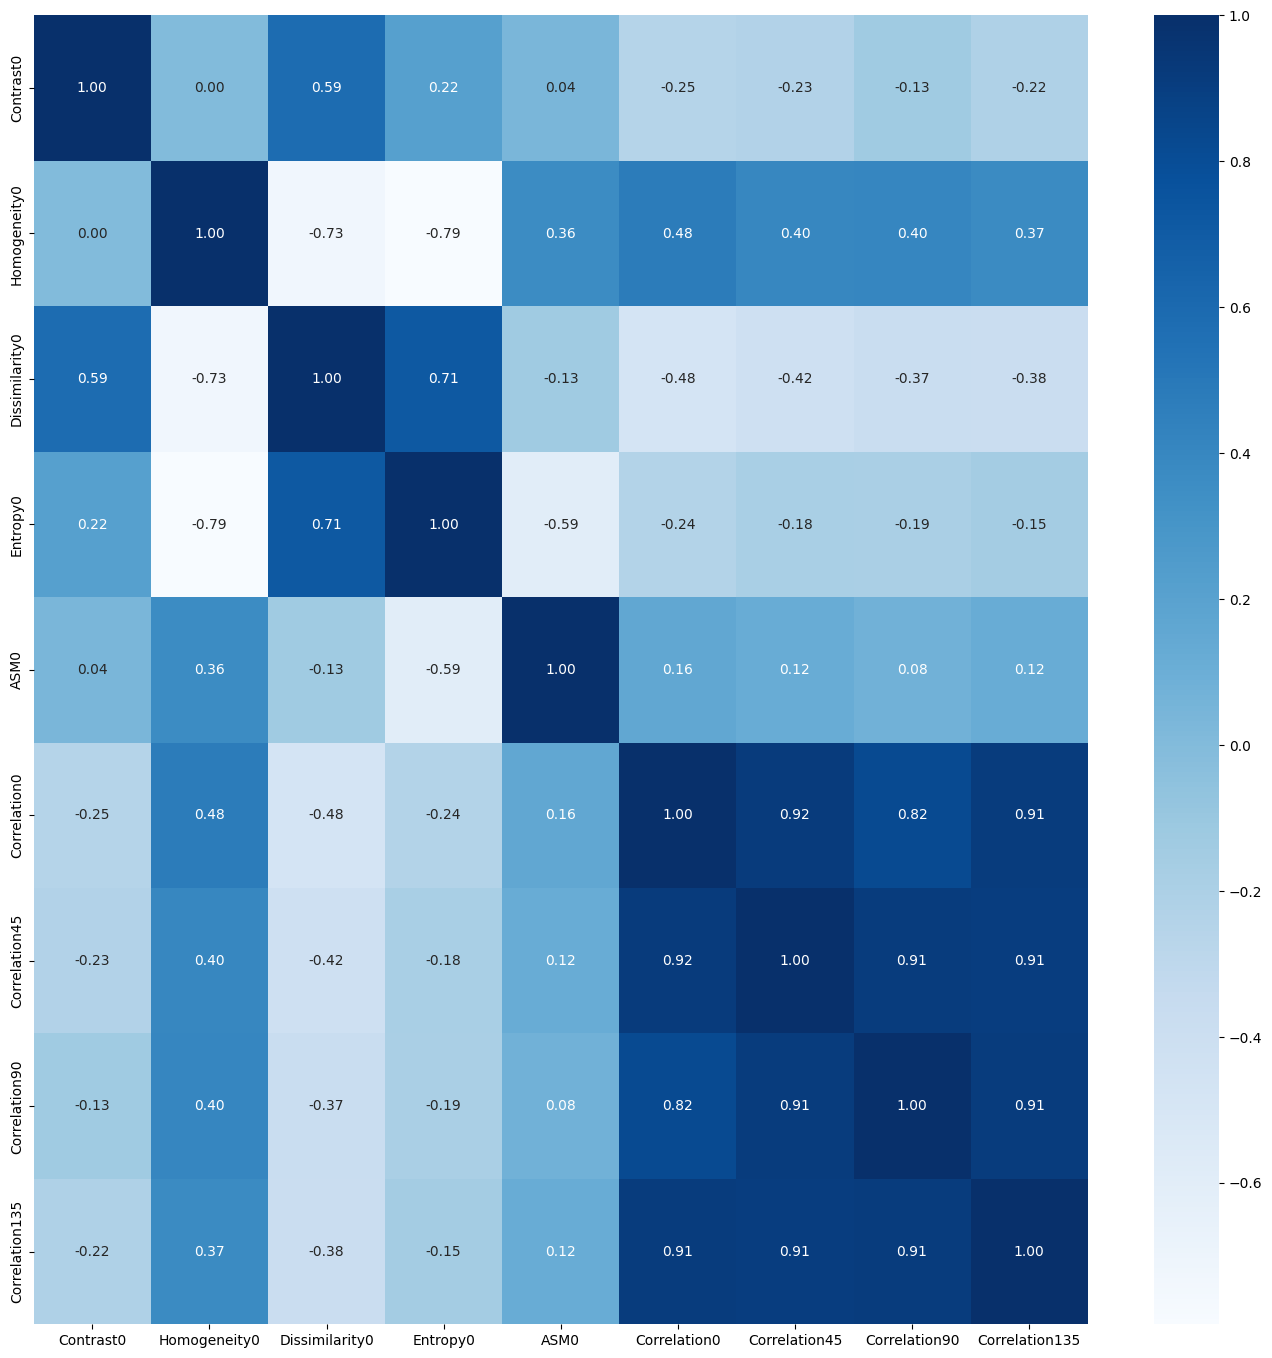

In [10]:
# Selection Correlation
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

### LDA

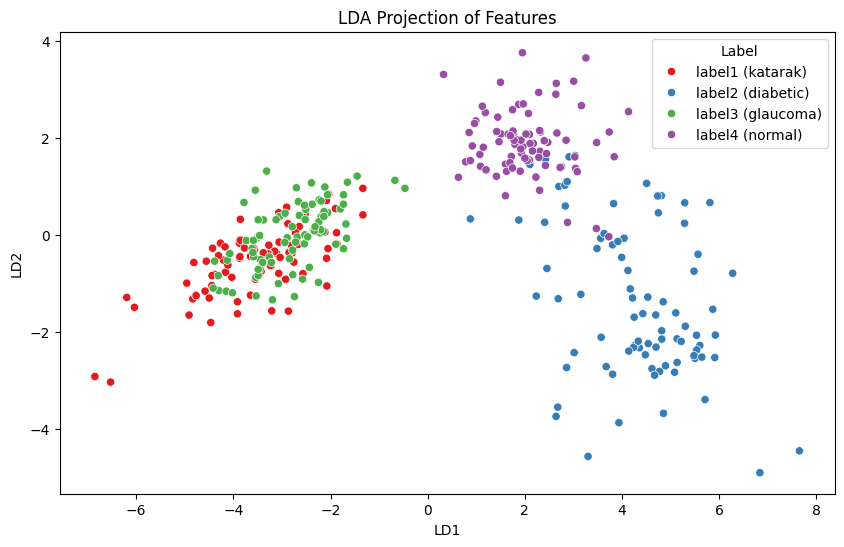

In [11]:
# Selection LDA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def feature_reduction_lda(dataframe, n_components=2):
    fitur = dataframe.drop(columns=['Label', 'Filename'])
    label = dataframe['Label']
    
    lda = LinearDiscriminantAnalysis(n_components=n_components)
    x_lda = lda.fit_transform(fitur, label)
    
    columns = [f'LD{i+1}' for i in range(n_components)]
    df_lda = pd.DataFrame(x_lda, columns=columns)
    df_lda['Label'] = label.values
    
    return df_lda

lda_df = feature_reduction_lda(hasilEkstrak, n_components=2)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=lda_df, x='LD1', y='LD2', hue='Label', palette='Set1')
plt.title('LDA Projection of Features')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(title='Label')
plt.show()

### t-SNE

c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


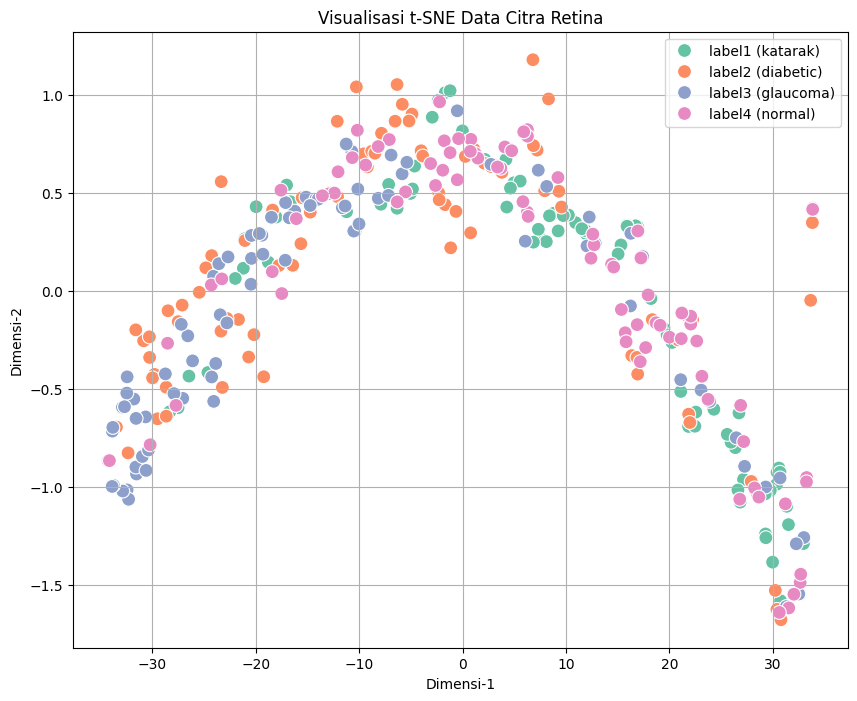

In [12]:
# Selection t-SNE

from sklearn.manifold import TSNE

# Jalankan t-SNE untuk reduksi ke 2 dimensi
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(x_new)

# Buat DataFrame hasil t-SNE
df_tsne = pd.DataFrame()
df_tsne['Dimensi-1'] = X_tsne[:, 0]
df_tsne['Dimensi-2'] = X_tsne[:, 1]
df_tsne['Label'] = y

# Plot dengan seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='Dimensi-1', y='Dimensi-2', hue='Label', data=df_tsne, palette='Set2', s=100
)
plt.title('Visualisasi t-SNE Data Citra Retina')
plt.legend(loc='best')
plt.grid(True)
plt.show()


## Splitting Data

In [13]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(268, 9)
(68, 9)
(268,)
(68,)


## Feature Normalization

In [14]:
# normalisasi mean std (Standardization / Z-score normalization)
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

### Define Model

In [15]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

In [16]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
                   precision    recall  f1-score   support

 label1 (katarak)       0.95      0.97      0.96        64
label2 (diabetic)       1.00      0.97      0.98        67
label3 (glaucoma)       0.99      0.96      0.97        72
  label4 (normal)       0.96      1.00      0.98        65

         accuracy                           0.97       268
        macro avg       0.97      0.97      0.97       268
     weighted avg       0.97      0.97      0.97       268

[[62  0  1  1]
 [ 0 65  0  2]
 [ 3  0 69  0]
 [ 0  0  0 65]]
Accuracy: 0.9738805970149254

------Testing Set------
                   precision    recall  f1-score   support

 label1 (katarak)       0.94      0.80      0.86        20
label2 (diabetic)       0.93      0.82      0.88        17
label3 (glaucoma)       0.55      0.92      0.69        12
  label4 (normal)       0.81      0.68      0.74        19

         accuracy                           0.79        68
        macro avg       0.81 

### Train SVM Classifier

In [17]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
                   precision    recall  f1-score   support

 label1 (katarak)       0.77      0.64      0.70        64
label2 (diabetic)       1.00      0.87      0.93        67
label3 (glaucoma)       0.70      0.78      0.74        72
  label4 (normal)       0.79      0.94      0.86        65

         accuracy                           0.81       268
        macro avg       0.82      0.81      0.81       268
     weighted avg       0.81      0.81      0.81       268

[[41  0 21  2]
 [ 0 58  0  9]
 [11  0 56  5]
 [ 1  0  3 61]]
Accuracy: 0.8059701492537313

------Testing Set------
                   precision    recall  f1-score   support

 label1 (katarak)       0.87      0.65      0.74        20
label2 (diabetic)       1.00      0.71      0.83        17
label3 (glaucoma)       0.55      0.92      0.69        12
  label4 (normal)       0.71      0.79      0.75        19

         accuracy                           0.75        68
        macro avg       0.78

### Train KNN Classifier

In [18]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
                   precision    recall  f1-score   support

 label1 (katarak)       0.81      0.80      0.80        64
label2 (diabetic)       0.95      0.90      0.92        67
label3 (glaucoma)       0.80      0.76      0.78        72
  label4 (normal)       0.79      0.89      0.84        65

         accuracy                           0.84       268
        macro avg       0.84      0.84      0.84       268
     weighted avg       0.84      0.84      0.84       268

[[51  0 11  2]
 [ 0 60  0  7]
 [11  0 55  6]
 [ 1  3  3 58]]
Accuracy: 0.835820895522388

------Testing Set------
                   precision    recall  f1-score   support

 label1 (katarak)       0.70      0.70      0.70        20
label2 (diabetic)       0.93      0.82      0.88        17
label3 (glaucoma)       0.41      0.58      0.48        12
  label4 (normal)       0.81      0.68      0.74        19

         accuracy                           0.71        68
        macro avg       0.71 

## Evaluasi Dengan Confussion Matrix

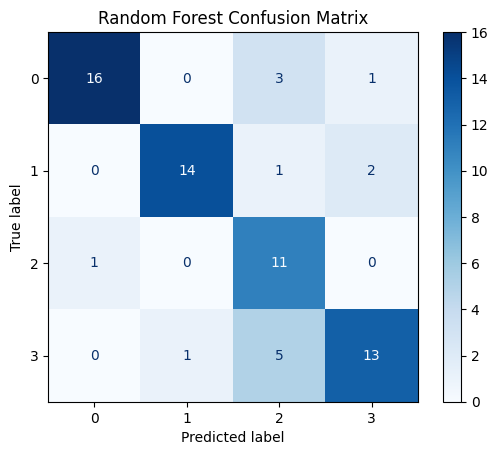

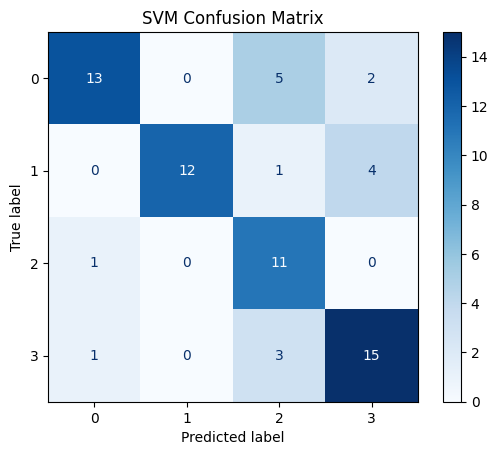

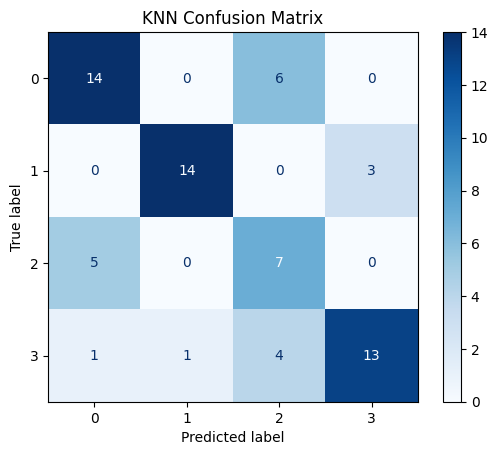

In [19]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")